In [1]:
# all imports
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import StandardScaler
import os
import time

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor,Resize,ColorJitter,CenterCrop,Grayscale
import torchvision.models as models

from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

In [2]:
# defining functions

# reads xml-data
def read_data(file):
    with open(file, 'r') as f:
        data = f.read()
    bs_data = bs(data, 'xml') 
    return bs_data


# gets the bname for calculations
def get_bname(path):
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            bs_data = read_data(path + xml_file)
            b_name = bs_data.find_all('name')
            return b_name    


# returns a dataframe given some data
def values_df(bs_data, low, high):
    b_name = bs_data.find_all('name')
    attributes = []
    # finds all values 
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(attributes)
    collection = {}
    
    # finds x-, y- and z-values and computes euclidian distance
    for i in range(low, high):
        r = calc(b_name, i)
        collection[attributes[i]] = r

    df = pd.DataFrame(collection)
    return df


# calculates the euclidian values
def calc(b_name, i):
    a1 = b_name[i].find_all('component')[0].get('data')
    b1 = b_name[i].find_all('component')[1].get('data')
    c1 = b_name[i].find_all('component')[2].get('data')
    x = np.asarray([float(x) for x in a1.split(',')])
    y = np.asarray([float(y) for y in b1.split(',')])
    z = np.asarray([float(z) for z in c1.split(',')])
    r = (x**2 + y**2 + z**2)**0.5
    return r


# calculates difference between max and min 
def get_differences_values(path, low, high):
    i = 0
    diff_list = []
    
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            try:
                bs_data = read_data(path + xml_file)
                b_name = bs_data.find_all('name')
                
                # fix since these values for some reason don't work when passed as arguments
                if low >= 3*int(len(b_name)/4):
                    low = 3*int(len(b_name)/4)
                    high = int(len(b_name))
                    
                df1 = values_df(bs_data, low, high)

                df_max = pd.DataFrame(df1.max().to_dict(),index=[df1.index.values[-1]])
                df_min = pd.DataFrame(df1.min().to_dict(),index=[df1.index.values[-1]])
                df1 = df_max.subtract(df_min, fill_value=0)
                df1 = df1.rename(index={100:i})

                diff_list.append(df1)
                i+=1
            except:
                 print(xml_file + " failed to compute")
        else:
            continue
            
    if "healthy" in path.lower():
        injurylevel = [0 for i in range(len(diff_list))]
    else: 
        injurylevel = [1 for i in range(len(diff_list))]
    data_level1 = pd.concat(diff_list)
    data_level1['Injury level'] = injurylevel
    print(f"Length of how many timeseries-files of {path} people we have between files {low} and {high}: {i}")

    return data_level1


# gets accuracy of the algorithms

def get_accuracy(algorithm, data, test_size):
    if algorithm == KNeighborsClassifier:
        classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    elif algorithm == RandomForestClassifier:
        classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    else:
        classifier = algorithm()
    y = data['Injury level']
    y = pd.DataFrame(y, columns = ['Injury level'])
    X = data.drop(['Injury level'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    sc = StandardScaler()
    X_train = sc.fit_transform(imputed_X_train)
    X_test = sc.transform(imputed_X_test)
    
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

# creating custom datasets

class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
def get_attributes():
    # get the attributes
    path = "USE THIS/PFPS/"
    xml_file = 'timeseries-11.xml'
    bs_data = read_data(path+xml_file)
    b_name = bs_data.find_all('name')

    attributes = []
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(set(attributes))
    return attributes
    

# returns probability of a person having PFPS
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    if y_pred_tag == y_test:
        return True
    else:
        return False

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features = 32, out_features = 16)
        self.fc2 = nn.Linear(in_features = 16, out_features = 8)
        self.out = nn.Linear(in_features = 8, out_features = 1)
        
    def forward(self, t):
        t = t
        
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.out(t)
        
        return t


## Preprocessing the data

Calculating the differences between the max and min-values in each attribute for each person in the four power levels.

In [5]:
# calculate the four power levels for healthy people:

path = "USE THIS/Healthy/"

b_name = get_bname(path)

diff_list1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list4 = get_differences_values(path, int(3*len(b_name)/4), int(len(b_name)))


# calculate the four power levels for injured people:

path = "USE THIS/PFPS/"

diff_list_injured1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list_injured2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list_injured3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list_injured4 = get_differences_values(path, int(3*len(b_name)/4), len(b_name))


# combine the data into the same dataframes


df_healthy = pd.concat([diff_list1, diff_list2, diff_list3, diff_list4])
df_pfps = pd.concat([diff_list_injured1, diff_list_injured2, diff_list_injured3, diff_list_injured4])
df_combined = pd.concat([df_healthy, df_pfps])

data3_level1 = pd.concat([diff_list1, diff_list_injured1]).reset_index(drop = True)
data3_level2 = pd.concat([diff_list2, diff_list_injured2]).reset_index(drop = True)
data3_level3 = pd.concat([diff_list3, diff_list_injured3]).reset_index(drop = True)
data3_level4 = pd.concat([diff_list4, diff_list_injured4]).reset_index(drop = True)


timeseries-10.xml failed to compute
timeseries-44.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 0 and 33: 21
timeseries-10.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 33 and 66: 22
timeseries-10.xml failed to compute
timeseries-23.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 66 and 99: 21
timeseries-10.xml failed to compute
timeseries-23.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 93 and 126: 21
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 0 and 33: 20
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 33 and 66: 20
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 66 and 99: 20
Length of how many timeseries-files of USE THIS/PFPS/ peop

## Preprocessing the data

Dividing the data into training and test data. 

In [6]:

y = df_combined['Injury level']
y = pd.DataFrame(y, columns = ['Injury level'])
X = df_combined.drop(['Injury level'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns

sc = StandardScaler()
X_train = sc.fit_transform(imputed_X_train)
X_test = sc.transform(imputed_X_test)

## Logistic regression

Calculates the confusion matrix, accuracy score and cross-validation scores using scikit-learn.

For further documentation please see [scikit-learn documentation](https://scikit-learn.org/stable/)

The confusion matrix is: 
 [[20  2]
 [ 4  7]]
The accuracy score is: 0.8181818181818182
The cross validation scores for logistic regression are [0.96296296 0.7037037  0.92307692 0.76923077 0.88461538]
The mean of the cross validation scores for logistic regression is: 0.8467032967032967


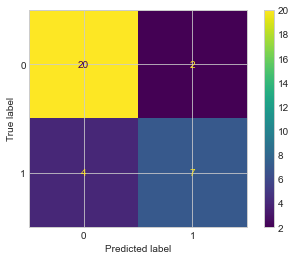

In [8]:
# Logistic Regression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
score1 = accuracy_score(y_test, y_pred)
print(f"The confusion matrix is: \n {cm}")
score2 = accuracy_score(y_test, y_pred)
print(f"The accuracy score is: {score1}")
scores = cross_val_score(classifier, X_train, y_train, cv=5)

print(f"The cross validation scores for logistic regression are {scores}")

print(f"The mean of the cross validation scores for logistic regression is: {np.mean(cross_val_score(classifier, X_train, y_train, cv=10))}")

y_pred = classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


## Random Forest

The confusion matrix is: 
 [[17  5]
 [ 1 10]]
The accuracy score is: 0.8181818181818182
The cross validation scores for random forest are [0.66666667 0.66666667 0.76923077 0.65384615 0.76923077]
The mean of the cross validation scores for random forest is: 0.7565934065934067


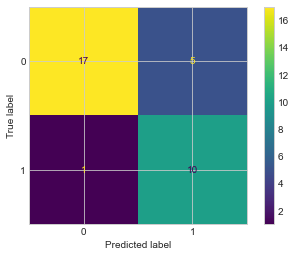

In [9]:
# Random Forest

forest_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
forest_classifier.fit(X_train, y_train)
y_pred = forest_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"The confusion matrix is: \n {cm}")
score2 = accuracy_score(y_test, y_pred)
print(f"The accuracy score is: {score2}")
scores = cross_val_score(forest_classifier, X_train, y_train, cv=5)

print(f"The cross validation scores for random forest are {scores}")

print(f"The mean of the cross validation scores for random forest is: {np.mean(cross_val_score(forest_classifier, X_train, y_train, cv=10))}")

y_pred = forest_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


## Feature importance for random forest



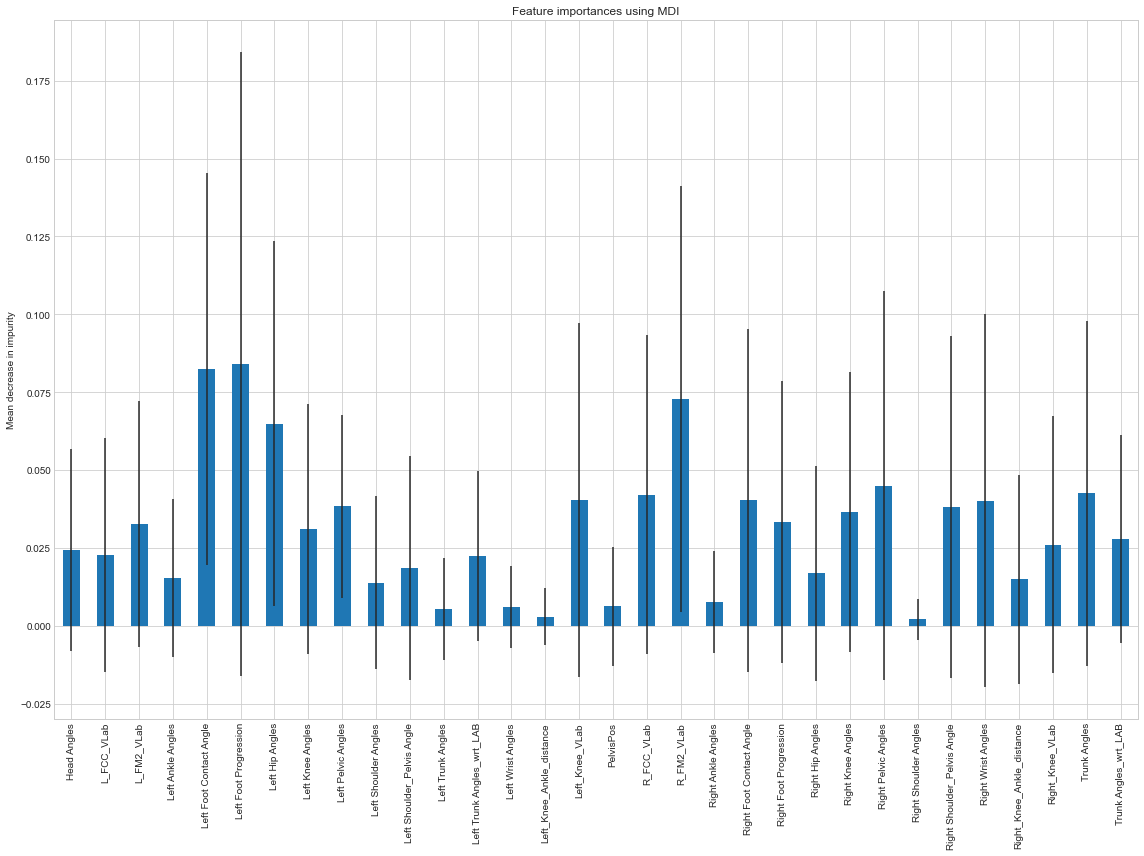

In [10]:
# calculate the feature importance for random forest

importances = forest_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_classifier.estimators_], axis=0)

X = df_combined.drop(['Injury level'], axis = 1)
attributes = [feature for feature in X.columns]

#attributes = get_attributes()

forest_importances = pd.Series(importances, index=attributes)

fig, ax = plt.subplots(figsize = (16,12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Text(0.5, 1.0, 'Random Forest feature importance')

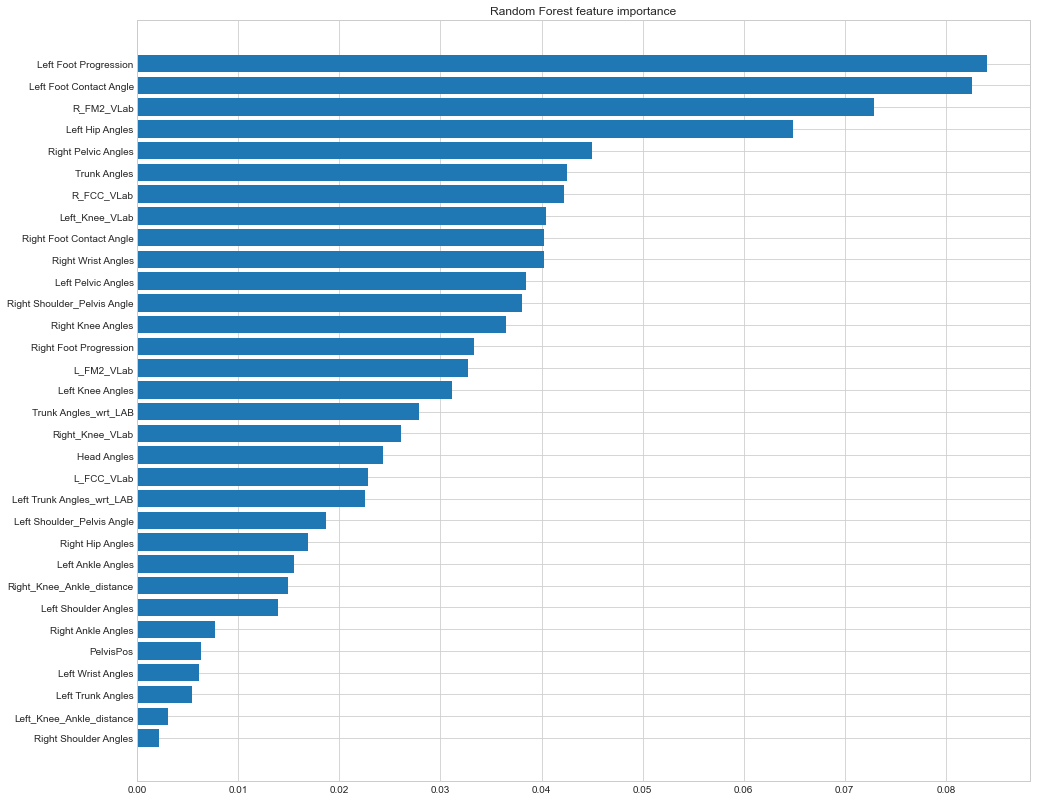

In [11]:
# feature importance

sorted_idx = forest_classifier.feature_importances_.argsort()

plt.figure(figsize = (16,14))
plt.barh(np.asarray(attributes)[sorted_idx], forest_classifier.feature_importances_[sorted_idx])
plt.title('Random Forest feature importance')

## Naive Bayes

The confusion matrix is: 
 [[18  4]
 [ 8  3]]
The accuracy score is: 0.6363636363636364
The cross validation scores for naive bayes are [0.59259259 0.48148148 0.73076923 0.46153846 0.65384615]
The mean of the cross validation scores for naive bayes is 0.6813186813186813


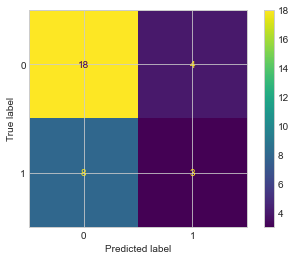

In [12]:
#Naive Bayes

naive_classifier = GaussianNB()
naive_classifier.fit(X_train, y_train)
y_pred = naive_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(f"The confusion matrix is: \n {cm}")
score3 = accuracy_score(y_test, y_pred)
print(f"The accuracy score is: {score3}")

scores = cross_val_score(naive_classifier, X_train, y_train, cv=5)
print(f"The cross validation scores for naive bayes are {scores}")

print(f"The mean of the cross validation scores for naive bayes is {np.mean(cross_val_score(naive_classifier, X_train, y_train, cv=10))}")

y_pred = naive_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## K-nearest neighbour (KNC) 

The confusion matrix is: 
 [[16  6]
 [ 4  7]]
The accuracy score is: 0.696969696969697
The cross validation scores for KNC are [0.7037037  0.55555556 0.73076923 0.73076923 0.65384615]
The mean of the cross validation scores for KNC is 0.6813186813186813


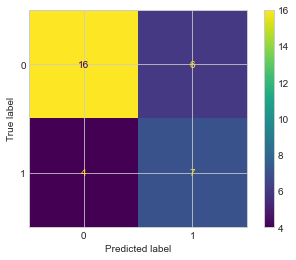

In [13]:
#KNC

KNC_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNC_classifier.fit(X_train, y_train)
y_pred = KNC_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(f"The confusion matrix is: \n {cm}")
score4 = accuracy_score(y_test, y_pred)
print(f"The accuracy score is: {score4}")

scores = cross_val_score(KNC_classifier, X_train, y_train, cv=5)
print(f"The cross validation scores for KNC are {scores}")

print(f"The mean of the cross validation scores for KNC is {np.mean(cross_val_score(KNC_classifier, X_train, y_train, cv=10))}")

y_pred = KNC_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## Linear support vector classification (SVC)

The confusion matrix is: 
 [[21  1]
 [ 3  8]]
The accuracy score is: 0.8787878787878788
The cross validation scores for SVC are [0.88888889 0.7037037  0.92307692 0.73076923 0.84615385]
The mean of the cross validation scores for SVC is 0.8692307692307691


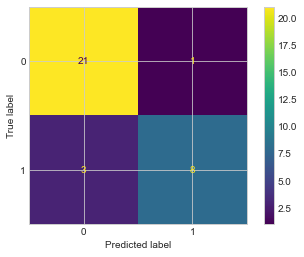

In [14]:
#SVC

SVC_classifier = SVC(kernel = 'linear', random_state = 0)
SVC_classifier.fit(X_train, y_train)
y_pred = SVC_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
score5 = accuracy_score(y_test, y_pred)
print(f"The confusion matrix is: \n {cm}")
print(f"The accuracy score is: {score5}")

scores = cross_val_score(SVC_classifier, X_train, y_train, cv=5)
print(f"The cross validation scores for SVC are {scores}")

print(f"The mean of the cross validation scores for SVC is {np.mean(cross_val_score(SVC_classifier, X_train, y_train, cv=10))}")

y_pred = SVC_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## XGBoost

[16:58:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The confusion matrix is: 
 [[19  3]
 [ 3  8]]
The accuracy score is: 0.8181818181818182
[16:58:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore 

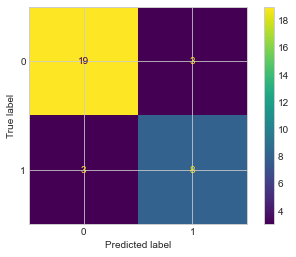

In [15]:
#XGB

XGB_classifier = XGBClassifier(use_label_encoder = False)
XGB_classifier.fit(X_train, y_train)
y_pred = XGB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
score6 = accuracy_score(y_test, y_pred)
print(f"The confusion matrix is: \n {cm}")
print(f"The accuracy score is: {score6}")
scores = cross_val_score(XGB_classifier, X_train, y_train, cv=5)
print(f"The cross validation scores for XGB are {scores}")

print(f"The mean of the cross validation scores for XGB is {np.mean(cross_val_score(XGB_classifier, X_train, y_train, cv=10))}")

y_pred = XGB_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## Feature importance for xgb

Text(0.5, 1.0, 'XBG feature importance')

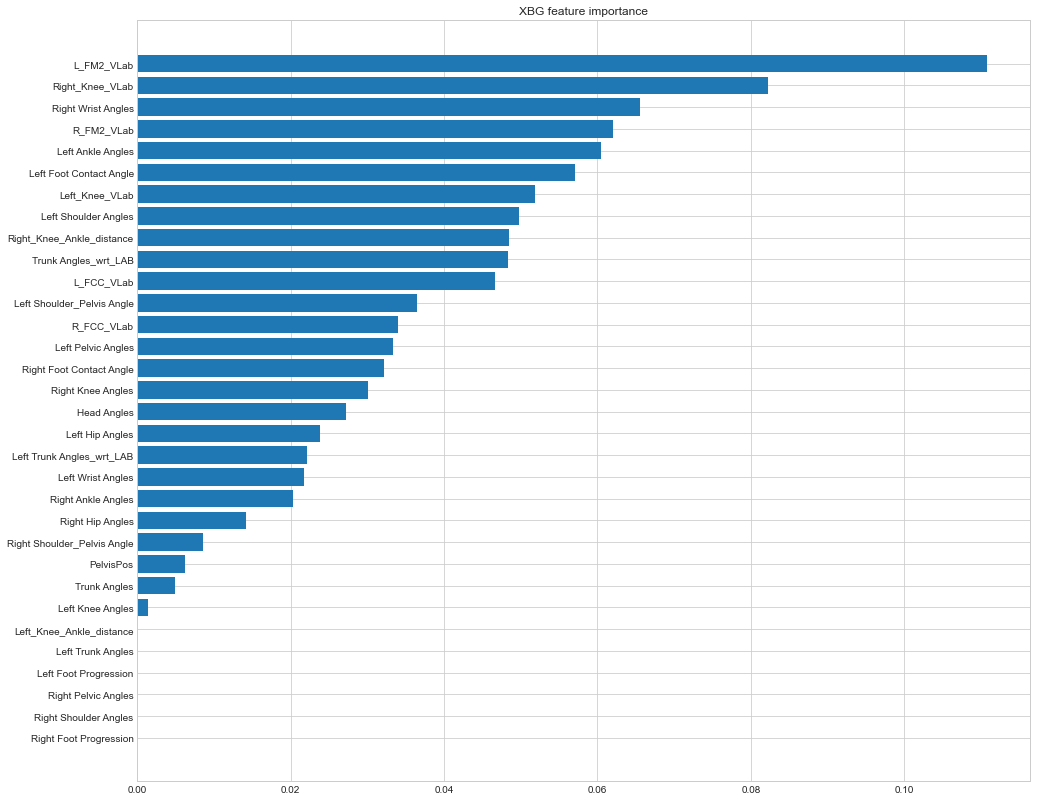

In [16]:
# feature importance for xgb

sorted_idx = XGB_classifier.feature_importances_.argsort()

plt.figure(figsize = (16,14))
plt.barh(np.asarray(attributes)[sorted_idx], XGB_classifier.feature_importances_[sorted_idx])
plt.title('XBG feature importance')

## Permutation feature importance for Random Forest

In [17]:
# random forest
forest = forest_classifier

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.002 seconds


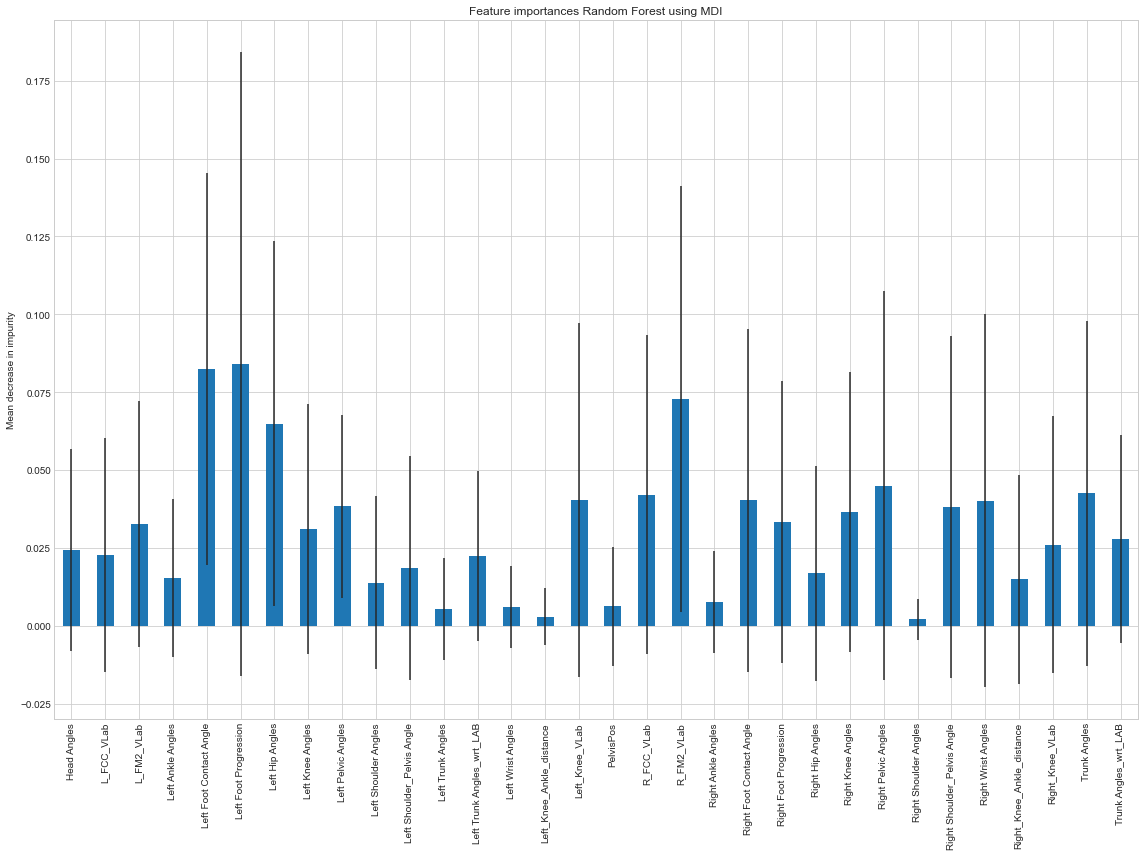

In [18]:
feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize = (16,12))

forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances Random Forest using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [19]:
start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 1.752 seconds


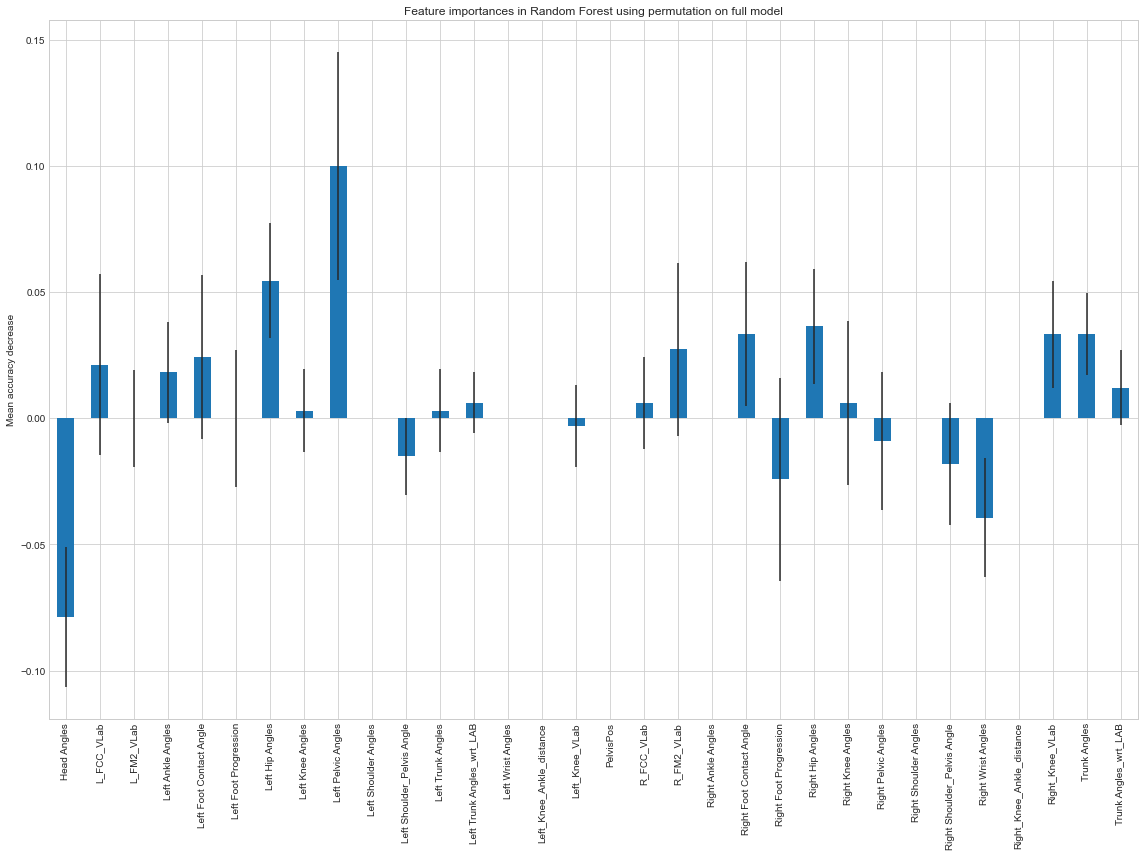

In [20]:
fig, ax = plt.subplots(figsize = (16,12))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances in Random Forest using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Permutation feature importance for xgb

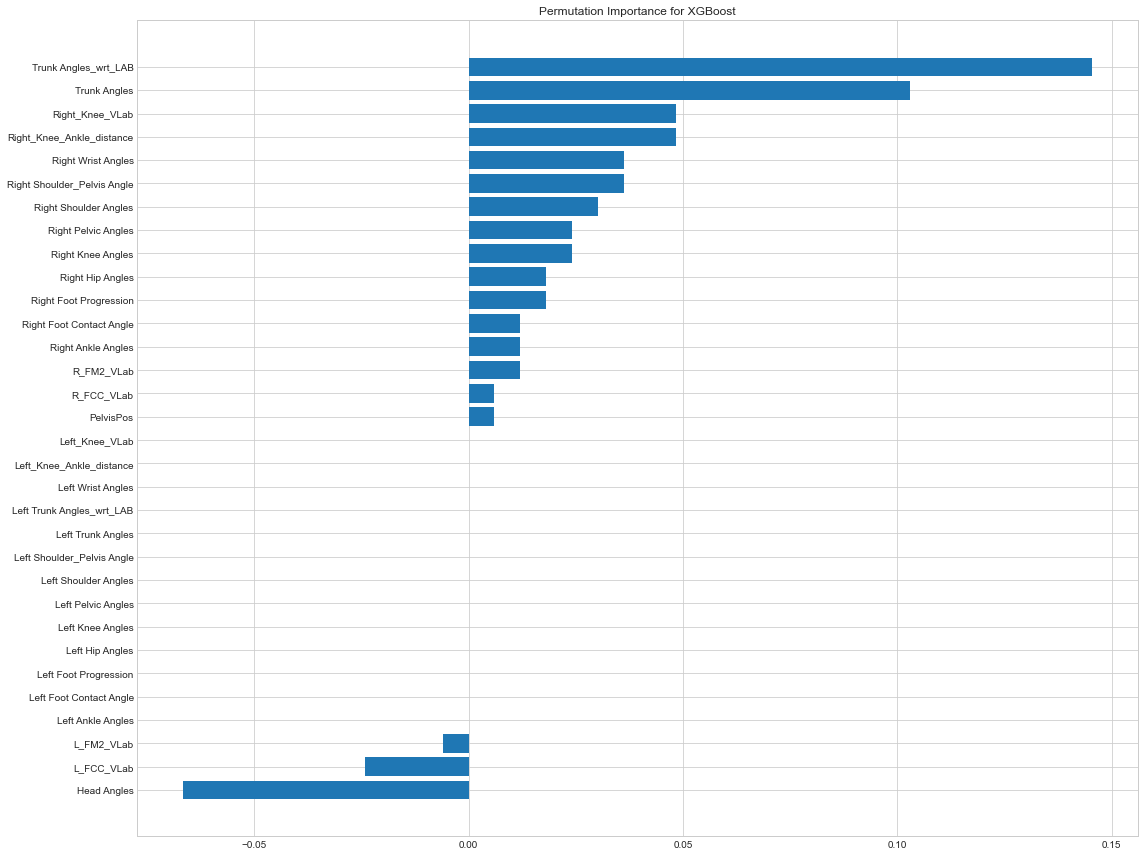

In [21]:
# xgboost
%matplotlib inline
feature_names = [feature for feature in X.columns]

fig, ax = plt.subplots(figsize = (16,12))
perm_importance = permutation_importance(XGB_classifier, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names, perm_importance.importances_mean[sorted_idx])
ax.set_title("Permutation Importance for XGBoost")
fig.tight_layout()

## Accuracy of the different algorithms

Calculates the accuracy of the different algorithms on the 4 different power levels, as well as on all of them combined.

In [22]:
rf1 = get_accuracy(RandomForestClassifier, data3_level1, 0.25)
rf2 = get_accuracy(RandomForestClassifier, data3_level2, 0.25)
rf3 = get_accuracy(RandomForestClassifier, data3_level3, 0.25)
rf4 = get_accuracy(RandomForestClassifier, data3_level4, 0.25)
rf5 = get_accuracy(RandomForestClassifier, df_combined, 0.25)

knc1 = get_accuracy(KNeighborsClassifier, data3_level1, 0.25)
knc2 = get_accuracy(KNeighborsClassifier, data3_level2, 0.25)
knc3 = get_accuracy(KNeighborsClassifier, data3_level3, 0.25)
knc4 = get_accuracy(KNeighborsClassifier, data3_level4, 0.25)
knc5 = get_accuracy(KNeighborsClassifier, df_combined, 0.25)

x1 = get_accuracy(XGBClassifier, data3_level1, 0.25)
x2 = get_accuracy(XGBClassifier, data3_level2, 0.25)
x3 = get_accuracy(XGBClassifier, data3_level3, 0.25)
x4 = get_accuracy(XGBClassifier, data3_level4, 0.25)
x5 = get_accuracy(XGBClassifier, df_combined, 0.25)

s1 = get_accuracy(SVC, data3_level1, 0.25)
s2 = get_accuracy(SVC, data3_level2, 0.25)
s3 = get_accuracy(SVC, data3_level3, 0.25)
s4 = get_accuracy(SVC, data3_level4, 0.25)
s5 = get_accuracy(SVC, df_combined, 0.25)

[16:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

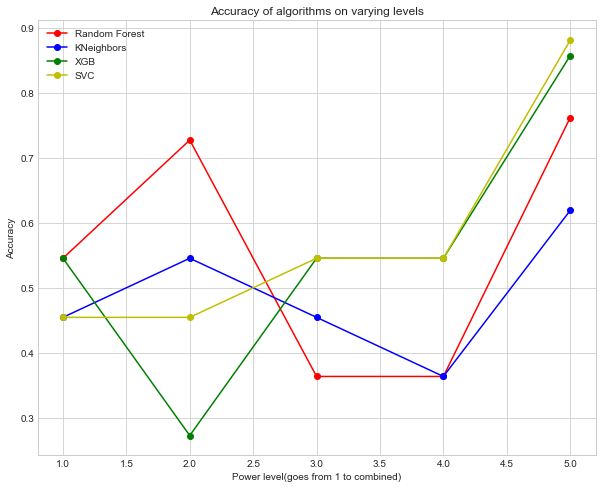

In [23]:
# plot the accuracy of the algorithms

plt.figure(figsize = (10,8))
plt.plot([1,2,3,4,5], [rf1,rf2,rf3,rf4,rf5], 'ro-', label = "Random Forest")
plt.plot([1,2,3,4,5], [knc1,knc2,knc3,knc4,knc5], 'bo-', label = "KNeighbors")
plt.plot([1,2,3,4,5], [x1,x2,x3,x4,x5], 'go-', label = "XGB")
plt.plot([1,2,3,4,5], [s1,s2,s3,s4,s5], 'yo-', label = "SVC")
plt.title("Accuracy of algorithms on varying levels")
plt.xlabel("Power level(goes from 1 to combined)")
plt.ylabel("Accuracy")
plt.legend()


## Neural Network using pytorch

In [24]:
# loading the data

train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.values))


test_data = TestData(torch.FloatTensor(X_test))
train_loader = DataLoader(dataset = train_data, batch_size = 1)
test_loader = DataLoader(dataset = test_data, batch_size = 1)

# training the model

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
model.train()
for i in range(1, epochs+1):
    epoch_loss = 0
    epoch_correct = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        if binary_acc(y_pred, y_batch):
            epoch_correct+=1
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    
    print(f'Epoch {i}: | Loss: {epoch_loss:.5f} | Correct: {epoch_correct} | Acc: {epoch_correct/len(train_loader):.3f}')

Epoch 1: | Loss: 86.94288 | Correct: 84 | Acc: 0.636
Epoch 2: | Loss: 67.89855 | Correct: 103 | Acc: 0.780
Epoch 3: | Loss: 47.22610 | Correct: 113 | Acc: 0.856
Epoch 4: | Loss: 35.22249 | Correct: 118 | Acc: 0.894
Epoch 5: | Loss: 23.35690 | Correct: 123 | Acc: 0.932
Epoch 6: | Loss: 18.04175 | Correct: 125 | Acc: 0.947
Epoch 7: | Loss: 17.51374 | Correct: 124 | Acc: 0.939
Epoch 8: | Loss: 10.44153 | Correct: 128 | Acc: 0.970
Epoch 9: | Loss: 23.45720 | Correct: 123 | Acc: 0.932
Epoch 10: | Loss: 4.64955 | Correct: 130 | Acc: 0.985


[[20  2]
 [ 2  9]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.82      0.82      0.82        11

    accuracy                           0.88        33
   macro avg       0.86      0.86      0.86        33
weighted avg       0.88      0.88      0.88        33



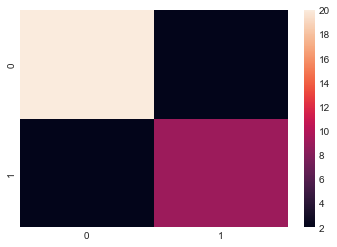

In [25]:
# testing the model

y_pred_list = []
model.eval()

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

cm = confusion_matrix(y_test, y_pred_list)
print(cm)
sns.heatmap(cm)
print(classification_report(y_test, y_pred_list))